### WORKFLOW
https://app.diagrams.net/#G1cV535YSmnTYzbPTn92zdyRegWAwrhzeD

### Stream camera described in Demo01

In [12]:
def stream_camera(config_filename, number_of_images=1):
    # Load JSON with configuration
    with open(config_filename) as cf:
        rs_cfg = o3d.t.io.RealSenseSensorConfig(json.load(cf))

    # Initialize device and get metadata
    rscam = o3d.t.io.RealSenseSensor()
    rscam.init_sensor(rs_cfg)
    rgbd_metadata = rscam.get_metadata()

    # Get intrinsic parameters from metadata
    fx = rgbd_metadata.intrinsics.intrinsic_matrix[0][0]
    fy = rgbd_metadata.intrinsics.intrinsic_matrix[1][1]
    ppx = rgbd_metadata.intrinsics.intrinsic_matrix[0][2]
    ppy = rgbd_metadata.intrinsics.intrinsic_matrix[1][2]
    height = rgbd_metadata.height
    width = rgbd_metadata.width

    # Start acquiring images
    rscam.start_capture(start_record=True)
    print('Waiting 2 seconds for camera to start...')
    time.sleep(2)
    print('Capturing frames')
    
    # Acquire number_of_images RGB and Depth frames
    camera_rgb_images = []
    camera_depth_images = []
    for _ in range(number_of_images):
        rgbd_frame = rscam.capture_frame(align_depth_to_color=True)
        color = rgbd_frame.color
        depth = rgbd_frame.depth

        camera_rgb_images.append(color)
        camera_depth_images.append(depth)

        # color_tensor = o3d.core.Tensor(color, dtype=o3d.core.Dtype.UInt8)
        # depth_tensor = o3d.core.Tensor(depth_filtered, dtype=o3d.core.Dtype.UInt16)
        # color_image = o3d.t.geometry.Image(color_tensor)
        # depth_image = o3d.t.geometry.Image(depth_tensor)
        # rgbd_frame = o3d.t.geometry.RGBDImage(color_image, depth_image)


    # Stop device
    rscam.stop_capture()

    # Return results
    return {"color":camera_rgb_images, "depth": camera_depth_images}, {"fx": fx, "fy": fy, "cx": ppx, "cy": ppy, "height": height, "width": width}

***
### trunc_depth described in Demo01

In [13]:
def trunc_depth(depth_frame, d):
    arr_img = np.asarray(depth_frame.to_legacy_image())
    arr_img[arr_img >= d] = 0
    tensor = o3d.core.Tensor(arr_img)
    image = o3d.t.geometry.Image(tensor)
    return image

***
### Bilateral filter described in Demo01

In [14]:
def bilateral_filter(depth_frame, d, sigma_color, sigma_space):
    arr_img = np.asarray(depth_frame.to_legacy_image()).astype(np.float32)
    arr_filtered = cv2.bilateralFilter(arr_img, d, sigma_color, sigma_space)
    tensor = o3d.core.Tensor(arr_filtered.astype(np.uint16))
    image = o3d.t.geometry.Image(tensor)
    return image

***
### tsdf_filter described in Demo01

In [15]:
def tsdf_filter(color_frames, depth_frames, camera_info, device):
    # TSDF volume initialization
    volume = o3d.t.geometry.TSDFVoxelGrid(
        map_attrs_to_dtypes={
            'tsdf': o3d.core.Dtype.Float32,
            'weight': o3d.core.Dtype.UInt16,
            'color': o3d.core.Dtype.UInt16
        },
        voxel_size=0.002,
        sdf_trunc=0.005,
        block_resolution=16,
        block_count=50000,
        device=device,
    )

    # Same camera, so transform is identity
    extrinsic = np.eye(4)
    extrinsic_gpu = o3d.core.Tensor(extrinsic, o3d.core.Dtype.Float32, device)
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width=camera_info["width"],
                                                  height=camera_info["height"],
                                                  fx=camera_info["fx"], fy=camera_info["fy"],
                                                  cx=camera_info["cx"], cy=camera_info["cy"])
    intrinsic_gpu = o3d.core.Tensor(intrinsic.intrinsic_matrix, o3d.core.Dtype.Float32, device)

    # Process each frame
    start = time.perf_counter()
    for color_frame, depth_frame in zip(color_frames, depth_frames):
        # Load images to gpu/cpu (depending on what you have chosen)
        color_gpu = color_frame.to(device)
        depth_gpu = depth_frame.to(device)
        volume.integrate(depth=depth_gpu,
                         color=color_gpu,
                         intrinsics=intrinsic_gpu,
                         extrinsics=extrinsic_gpu,
                         depth_scale=1000.0,
                         depth_max=1.2,
                         )

    end = time.perf_counter()
    print('Mean compute time:', (end - start) / len(color_frames) * 1000, ' [ms]')

    # Extract point cloud from volume
    return_value = volume.cpu().extract_surface_points()

    # But not sure whether this works or not...
    o3d.core.cuda.release_cache()
    return return_value

***
### Radius outlier removal described in Demo01

In [16]:
def radius_outlier_removal(point_cloud, nb_points, radius):
    point_cloud = point_cloud.to_legacy_pointcloud()
    _, ind = point_cloud.remove_radius_outlier(nb_points, radius)
    point_cloud = point_cloud.select_by_index(ind)
    point_cloud_gpu = o3d.t.geometry.PointCloud.from_legacy_pointcloud(point_cloud)
    return point_cloud_gpu

***
### statistical outlier removal described in Demo01

In [17]:
def statistical_outlier_removal(point_cloud, nb_neighbors, std_ratio):
    point_cloud = point_cloud.to_legacy_pointcloud()
    _, ind = point_cloud.remove_statistical_outlier(nb_neighbors, std_ratio)
    point_cloud = point_cloud.select_by_index(ind)
    point_cloud_gpu = o3d.t.geometry.PointCloud.from_legacy_pointcloud(point_cloud)
    return point_cloud_gpu

***
### mask depth function
This function is cutting off given area of the scene. User should define the region of the interest (RoI) himself. RoI must be represented as a binary image of size matching depth image size. Function performs multiplying of mask and depth image.

* input
    - camera_idx - index of the camera (in user-defined manner, to automatize reading masks)
    - depth - list of depth images
* output
    - masked_depth - list of masked images

In [18]:
def mask_depth(cam_idx: int, depth: list):
    
    masked_depth = []
    if cam_idx == 5 or cam_idx == 2:
        return depth
    mask_path = "input/intel_masks/mask_cam" + str(cam_idx) + ".png"
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = (mask / np.max(mask)).astype(np.uint16)
    for i in range(len(depth)):
        image_masked = np.asarray(depth[i].to_legacy_image()) * mask
        tensor = o3d.core.Tensor(image_masked)
        masked_depth.append(o3d.t.geometry.Image(tensor))
    return masked_depth

***
### icp preprocess pointcloud function
Performs voxelization of given pointcloud and estimates its normals.

* input
    * pcd - pointcloud to be processed
    * voxel_size - voxel size of the resulting voxelgrid
* output
    * pcd_down - voxelgrid with normal values

In [19]:
def icp_preprocess_pointcloud(pcd, voxel_size):
    pcd_down = pcd.voxel_down_sample(voxel_size)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2.0,
                                             max_nn=30))

    return pcd_down

***
### get tf from icp function
Perform ICP pointcloud registration in order to acquire camera aligning transformations. For now, this functions uses CPU only.

* input
    * source - pointcloud to be fitted to target
    * target - base pointcloud to which the source pointcloud is being fitted
    * voxel_size - voxel size used in feature matching process
    * initial_transformation - initial transformation roughly aligning source to target pointcloud
    * max_iter - maximum number of ICP iterations
* output
    * transformation aligning source to target pointcloud

In [20]:
def get_tf_from_icp(source, target, voxel_size, initial_transformation, max_iter=200):
    current_transformation = initial_transformation
    source_down = icp_preprocess_pointcloud(source, voxel_size)
    target_down = icp_preprocess_pointcloud(target, voxel_size)

    print("Colored point cloud registration")
    result_icp = o3d.pipelines.registration.registration_colored_icp(
        source_down, target_down, voxel_size, current_transformation,
        o3d.pipelines.registration.TransformationEstimationForColoredICP(),
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-7,
                                                          relative_rmse=1e-7,
                                                          max_iteration=max_iter))
    print(result_icp)
    return result_icp.transformation

***
### tsdf_scene_cloud function
This function uses TSDF to merge point clouds from given cameras. Input frames must be passed in a nested list. Outer list is camera-indexed and the inner one is frame-indexed. Length of camera-indexed part must be same as length of cameras_info list (and the order must be kept).

* input
    * frames_color - list of list of color images,
    * frames_depth - list of list of depth images,
    * cameras_info - list of cameras instrinsic,
    * transforms - list of cameras extrinsic,
    * device - only CUDA device Open3D object.
* output
    * return_value - merged point cloud

In [21]:
def tsdf_scene_cloud(frames_color,
                     frames_depth,
                     cameras_info, 
                     transforms,
                     device):
    
    volume = o3d.t.geometry.TSDFVoxelGrid(
        map_attrs_to_dtypes={
            'tsdf': o3d.core.Dtype.Float32,
            'weight': o3d.core.Dtype.UInt16,
            'color': o3d.core.Dtype.UInt16
        },
        voxel_size=0.002,
        sdf_trunc=0.005,
        block_resolution=16,
        block_count=50000,
        device=device,)
      
    extrinsic_gpu = []
    intrinsic_gpu = []
    
    for camera_info, transform in zip(cameras_info, transforms):
        extrinsic_gpu.append(o3d.core.Tensor(np.linalg.inv(transform), o3d.core.Dtype.Float32, device))
        pinhole_temporary = o3d.camera.PinholeCameraIntrinsic(width=camera_info["width"],
                                                  height=camera_info["height"],
                                                  fx=camera_info["fx"], fy=camera_info["fy"],
                                                  cx=camera_info["cx"], cy=camera_info["cy"])
        intrinsic_gpu.append(o3d.core.Tensor(pinhole_temporary.intrinsic_matrix, o3d.core.Dtype.Float32, device))     
        
    for i in range(len(frames_depth)):
        for j in range(len(frames_depth[i])):
            color_gpu = frames_color[i][j].to(device)
            depth_gpu = frames_depth[i][j].to(device)
            volume.integrate(depth=depth_gpu,
                             color=color_gpu,
                             intrinsics=intrinsic_gpu[i],
                             extrinsics=extrinsic_gpu[i],
                             depth_scale=1000.0,
                             depth_max=1.2,
                             )
    return_value = volume.cpu().extract_surface_points()
    o3d.core.cuda.release_cache()

    return return_value

***
# PIPELINE


### 0. Imports

In [22]:
import cv2
import open3d as o3d
from open3d.web_visualizer import draw
import time
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


### 1. Choose device and amount of frames to be merged for each camera

In [23]:
frames_no = 100
device = o3d.core.Device("CUDA:0")

### 2. How many cameras?

In [24]:
cameras_no = 6

### 2. Acquire color and depth frames from each camera. Additionaly, save camera inforamtions (extrinsic, intrinsic and picture size)

In [25]:
depth_frames_all_cameras = []
color_frames_all_cameras = []
camera_info_all_cameras = []

for i in range(1, cameras_no+1):
    config_filename = "input/cam" + str(i) + "_config.json"
    data, camera_information = stream_camera(config_filename, frames_no)
    depth_frames_all_cameras.append(data["depth"])
    color_frames_all_cameras.append(data["color"])
    camera_info_all_cameras.append(camera_information)

Waiting 2 seconds for camera to start...[Open3D INFO] Capture started with RealSense camera 114122250518

Capturing frames
[Open3D INFO] Capture stopped.
Waiting 2 seconds for camera to start...
[Open3D INFO] Capture started with RealSense camera 053422251478
Capturing frames
[Open3D INFO] Capture stopped.
Waiting 2 seconds for camera to start...[Open3D INFO] Capture started with RealSense camera 135222252292

Capturing frames
[Open3D INFO] Capture stopped.
Waiting 2 seconds for camera to start...[Open3D INFO] Capture started with RealSense camera 135122250228

Capturing frames
[Open3D INFO] Capture stopped.
Waiting 2 seconds for camera to start...[Open3D INFO] Capture started with RealSense camera 114122250435

Capturing frames
[Open3D INFO] Capture stopped.
Waiting 2 seconds for camera to start...[Open3D INFO] Capture started with RealSense camera 114122250221

Capturing frames
[Open3D INFO] Capture stopped.


### 3. Truncate depth frames

In [27]:
depth_frames_truncated = depth_frames_all_cameras.copy()
for i, camera in enumerate(depth_frames_all_cameras):
    for j, frame in enumerate(camera):
        depth_frames_truncated[i][j] = trunc_depth(frame, 2000)
        

##  (!) IMPORTANT - VERIFY ALL CAMERAS RESULTS
### If any of the images is invalid, replug the camera

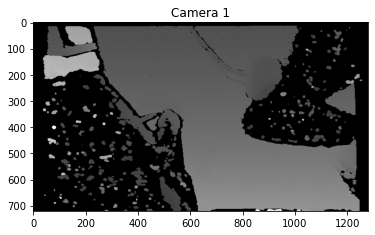

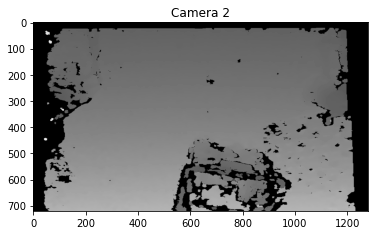

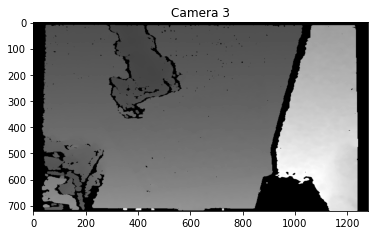

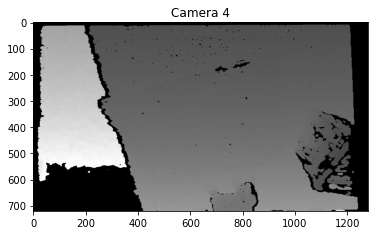

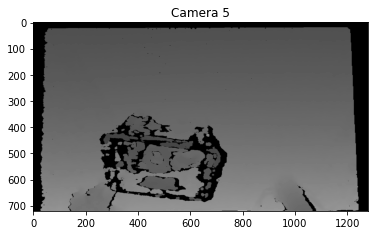

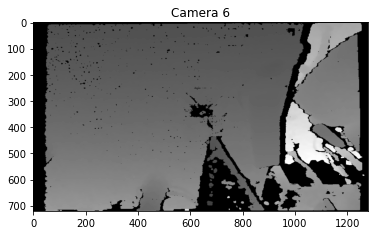

In [28]:
for i, camera in enumerate(depth_frames_truncated):
    plt.imshow(camera[0].to_legacy_image(), cmap='gray')
    plt.title(f"Camera {i+1}")
    plt.show()

### 4. Apply out-of-the-table mask

In [29]:
masked_depth = []
for j, camera in enumerate(depth_frames_truncated):
    masked_depth.append(mask_depth(j+1, camera))
        

### 4.1 Previewing masked image

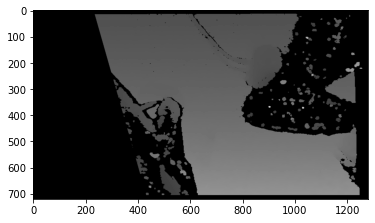

In [30]:
plt.imshow(masked_depth[0][0].to_legacy_image(), cmap='gray')
plt.show()

### 5 Apply bilateral filter

In [31]:
bilateral_depth = masked_depth.copy()
for i, camera in enumerate(masked_depth):
    for j, frame in enumerate(camera):
        bilateral_depth[i][j] = bilateral_filter(frame, 5, 15, 30)

### 5.1 Previewing bilateral filter results

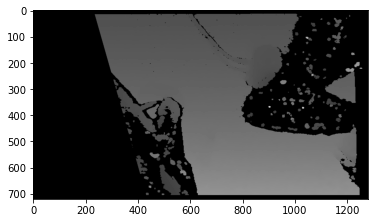

In [32]:
plt.imshow(bilateral_depth[0][0].to_legacy_image(), cmap='gray')
plt.show()

### 6. Apply TSDF

In [33]:
tsdf_all_cameras = []
for camera_color, camera_depth, camera_info in zip(color_frames_all_cameras, bilateral_depth, camera_info_all_cameras):
    tsdf_all_cameras.append(tsdf_filter(camera_color, camera_depth, camera_info, device))

Mean compute time: 2.3170379499788396  [ms]
[Open3D WARNING] No estimated max point cloud size provided, using a 2-pass estimation. Surface extraction could be slow.
Mean compute time: 1.9115360599244013  [ms]
[Open3D WARNING] No estimated max point cloud size provided, using a 2-pass estimation. Surface extraction could be slow.
Mean compute time: 1.7486982498667203  [ms]
[Open3D WARNING] No estimated max point cloud size provided, using a 2-pass estimation. Surface extraction could be slow.
Mean compute time: 1.7722829998820089  [ms]
[Open3D WARNING] No estimated max point cloud size provided, using a 2-pass estimation. Surface extraction could be slow.
Mean compute time: 1.917546580079943  [ms]
[Open3D WARNING] No estimated max point cloud size provided, using a 2-pass estimation. Surface extraction could be slow.
Mean compute time: 1.7693004998727702  [ms]
[Open3D WARNING] No estimated max point cloud size provided, using a 2-pass estimation. Surface extraction could be slow.


### 6.1 Preview TSDF results (one camera)

In [35]:
draw(tsdf_all_cameras[0])

[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.7121034709776202
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.7121034709776202
[Open3D INFO] Sending init frames to window_1.


### 6.2 Remove outliers

##### 6.2.1 Radius based outlier removal

In [36]:
tsdf_no_outliers_pcds=[]
for pcd in tsdf_all_cameras:
    tsdf_no_outliers_pcds.append(radius_outlier_removal(pcd,20, 0.05))

[000:000][26625] (stun_port.cc:96): Binding request timed out from 10.3.15.x:51917 (enp4s0)
[025:187][26625] (stun_port.cc:96): Binding request timed out from 10.3.15.x:48901 (enp4s0)


#### 6.2.1.1 Previewing filtered pointcloud

In [37]:
draw(tsdf_no_outliers_pcds[0])

[Open3D INFO] Window window_2 created.


WebVisualizer(window_uid='window_2')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate


##### 6.2.2 Statistics based outlier removal

In [38]:
filtered_tsdf = []
for pcd in tsdf_no_outliers_pcds:
    filtered_tsdf.append(statistical_outlier_removal(pcd, 16, 0.05))

#### 6.2.2.1 Previewing filtered pointcloud

In [39]:
draw(filtered_tsdf[0])

[Open3D INFO] Window window_3 created.


WebVisualizer(window_uid='window_3')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.5825839782158198
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.5825839782158198
[Open3D INFO] Sending init frames to window_2.
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.3793880353936949
[Open3D INFO] DataChannelObserver:

[067:769][26625] (stun_port.cc:96): Binding request timed out from 10.3.15.x:55435 (enp4s0)
[067:795][26625] (stun_port.cc:96): Binding request timed out from 10.3.15.x:51662 (enp4s0)


### 6.3 Save TSDF results

In [40]:
for i in range(len(filtered_tsdf)):
    o3d.io.write_point_cloud("output/tsdf_pcd_"+str(i)+".ply",tsdf_all_cameras[i].to_legacy_pointcloud())

[Open3D WARNING] Write Ply clamped color value to valid range
[Open3D WARNING] Write Ply clamped color value to valid range
[Open3D WARNING] Write Ply clamped color value to valid range
[Open3D WARNING] Write Ply clamped color value to valid range
[Open3D WARNING] Write Ply clamped color value to valid range


### 7. Perform ICP registration 

### 7.1 Load initial transforms (hand made estimation!!!)

In [41]:
initial_transforms = []

# cam 1 to 5
initial_transforms.append(np.array([[-0.99992822, -0.00785575, 0.01269645, 0.74838714],
                                    [-0.00707733, -0.51743752, -0.85513151, 0.91575246],
                                    [0.01258807, -0.85511619, 0.51735471, 0.51723005],
                                    [0., 0., 0., 1.]]))
# cam 2 to 5
initial_transforms.append(np.array([[-0.99997, -0.00399, -0.01043, -0.01052],
                                    [0.01065, -0.53904, -0.84164, 0.91812],
                                    [-0.00297, -0.84169, 0.53908, 0.50068],
                                    [0.00000, 0.00000, 0.00000, 1.00000]]))
# cam 3 to 5
initial_transforms.append(np.array([[-0.99943459, -0.01711072, -0.03031056, -0.78419639],
                                    [0.03446086, -0.5430283, -0.83842069, 0.92078797],
                                    [-0.00281918, -0.83896036, 0.5433222, 0.49895985],
                                    [0., 0., 0., 1.]]))
# cam 4 to 5
initial_transforms.append(np.array([[0.99994475, -0.00681823, -0.0080003, -0.79528481],
                                    [0.0068453, 0.99997092, 0.00336047, -0.00240824],
                                    [0.00797716, -0.00341505, 0.99996235, -0.00884436],
                                    [0., 0., 0., 1.]]))
# cam 5 to 5
initial_transforms.append(np.eye(4))

# cam 6 to 5
initial_transforms.append(np.array([[0.99994475, -0.00681823, -0.0080003, 0.79528481],
                                    [0.0068453, 0.99997092, 0.00336047, -0.00240824],
                                    [0.00797716, -0.00341505, 0.99996235, -0.00884436],
                                    [0., 0., 0., 1.]]))

voxel_size = 0.001

### 7.2 Transfer pointclouds to CPU

In [42]:
device_cpu = o3d.core.Device("CPU:0")

for i in range(len(tsdf_all_cameras)):
    tsdf_all_cameras[i] = filtered_tsdf[i].to(device_cpu).to_legacy_pointcloud()

#### 7.3 Perform ICP registration

In [43]:
icp_results=[]
for i in range(len(tsdf_all_cameras)):
    icp_results.append(get_tf_from_icp(tsdf_all_cameras[i],tsdf_all_cameras[4],0.001,initial_transforms[i]))

Colored point cloud registration
RegistrationResult with fitness=2.517449e-02, inlier_rmse=7.570678e-04, and correspondence_set size of 6460
Access transformation to get result.
Colored point cloud registration
RegistrationResult with fitness=2.979340e-02, inlier_rmse=7.717449e-04, and correspondence_set size of 11671
Access transformation to get result.
Colored point cloud registration
RegistrationResult with fitness=2.112435e-02, inlier_rmse=7.650289e-04, and correspondence_set size of 6601
Access transformation to get result.
Colored point cloud registration
RegistrationResult with fitness=8.446589e-03, inlier_rmse=7.591355e-04, and correspondence_set size of 2596
Access transformation to get result.
Colored point cloud registration
RegistrationResult with fitness=1.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 409961
Access transformation to get result.
Colored point cloud registration
RegistrationResult with fitness=8.827851e-02, inlier_rmse=7.672248e-04, an

#### 7.3.1 Previewing registration results

In [44]:
icp_results

[array([[-0.99945456, -0.02109805,  0.02734282,  0.73683851],
        [-0.01328539, -0.50305919, -0.86359754,  0.92335359],
        [ 0.03129014, -0.86343113,  0.50251234,  0.52605296],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.99983257,  0.01687812, -0.00913656, -0.00430132],
        [-0.00151107, -0.53099386, -0.84680943,  0.91893019],
        [-0.01986918, -0.84663023,  0.53094655,  0.4992966 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.99941109,  0.03368979,  0.00754014, -0.79781882],
        [-0.02464154, -0.53238331, -0.84558403,  0.89647775],
        [-0.02520441, -0.84525736,  0.53291443,  0.48816074],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.99948325, -0.00156132,  0.03210581, -0.81231734],
        [ 0.00203692,  0.9998886 , -0.01478587,  0.01380458],
        [-0.03207915,  0.01484362,  0.9993751 ,  0.00211247],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),


#### 8. Transofrm pointclouds (pure - without TSDF - just to compare)

In [46]:
pcd_tf=[copy.deepcopy(tsdf_all_cameras[i]).transform(icp_results[i]) for i in range(len(tsdf_all_cameras))]

#### 8.1 Previewing results

In [48]:
draw(pcd_tf)

[Open3D INFO] Window window_5 created.


WebVisualizer(window_uid='window_5')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.750266184176954
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.750266184176954
[Open3D INFO] Sending init frames to window_5.


[304:777][26625] (stun_port.cc:96): Binding request timed out from 10.3.15.x:54367 (enp4s0)


#### 9. Define device for last stage of merging (with TSDF)

In [49]:
device = o3d.core.Device("CUDA:0")

#### 10. Perform TSDF of all cameras

In [50]:
final = tsdf_scene_cloud(color_frames_all_cameras,
                 bilateral_depth,
                 camera_info_all_cameras,
                 icp_results,
                 device)

[Open3D WARNING] No estimated max point cloud size provided, using a 2-pass estimation. Surface extraction could be slow.


#### 10.1 Previewing final results

In [52]:
draw(final)
# o3d.io.write_point_cloud("output/final_pointcloud.ply",final.to_legacy_pointcloud())

[Open3D INFO] Window window_7 created.


WebVisualizer(window_uid='window_7')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.4081602957808874
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.4081602957808874
[Open3D INFO] Sending init frames to window_7.


#### 11. Final filtering

In [53]:
final_filtered = radius_outlier_removal(final, 1500, 0.05) # between 1500 and 2000

#### 11.1 Final filtering previewing

In [54]:
draw(final_filtered)
# o3d.io.write_point_cloud("output/final_filtered_pointcloud.ply",final_filtered.to_legacy_pointcloud())

[Open3D INFO] Window window_8 created.


WebVisualizer(window_uid='window_8')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.555985093480637
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.555985093480637
[Open3D INFO] Sending init frames to window_8.


[447:551][26625] (stun_port.cc:96): Binding request timed out from 10.3.15.x:43541 (enp4s0)
[472:589][26625] (stun_port.cc:96): Binding request timed out from 10.3.15.x:57876 (enp4s0)
